# Analyze NetBERT improvements over BERT predictions
The goal is to extract the right predictions of BERT-base on the dev set, and pass only these subset to NetBERT to see if it performs at least as well as BERT-base. Then, extract the wrong predictions of BERT-base and see where NetBERT improves, which specific cases, which classes in particluar, which type of sentences (badly written, not clear?)

In [1]:
import os
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

## 1. Prepare eval datasets from bert-base predictions

In [35]:
def create_eval_dataset(infile, outfile, class_mappings):
    """
    """
    # Load right predictions from BERT-base
    df = pd.read_csv(os.path.join(dirpath, infile), index_col=0)

    # Create columns with classes.
    df['Class'] = df.apply(lambda row: class_mappings[str(row.Class_id)], axis=1)
    df['Prediction'] = df.apply(lambda row: class_mappings[str(row.Prediction_id)], axis=1)

    # Drop useless columns.
    to_drop = ['Class_id', 'Prediction_id', 'Prediction']
    df.drop(to_drop, axis=1, inplace=True)
    
    # Save dataset for evaluation with NetBERT.
    df.to_csv(os.path.join(dirpath, outfile))
    return df


# Load class-class_id mapping.
dirpath = '/raid/antoloui/Master-thesis/Code/Extrinsic_evaluation/Classification/output/bert_base_cased/'
with open(os.path.join(dirpath, 'map_classes.json')) as f:
    class_mappings = json.load(f)

# Create eval dataset from BERT-base right predictions.
df_bert_right = create_eval_dataset(infile='preds_right.csv', outfile='eval_right_preds.csv', class_mappings=class_mappings)

# Create eval dataset from BERT-base wrong predictions.
df_bert_wrong = create_eval_dataset(infile='preds_wrong.csv', outfile='eval_wrong_preds.csv', class_mappings=class_mappings)

# Create full test dataset.
df_bert = pd.concat([df_bert_right,df_bert_wrong], ignore_index=True)
df_bert.to_csv(os.path.join(dirpath, 'eval_preds.csv'))

## 2. Analysis

In [51]:
def load_dataset(dirpath, filepath, class_mappings):
    """
    """
    # Load right predictions from BERT-base
    df = pd.read_csv(os.path.join(dirpath, filepath), index_col=0)

    # Create columns with classes.
    df['Class'] = df.apply(lambda row: class_mappings[str(row.Class_id)], axis=1)
    df['Prediction'] = df.apply(lambda row: class_mappings[str(row.Prediction_id)], axis=1)

    # Drop useless columns.
    to_drop = ['Class_id', 'Prediction_id']
    df.drop(to_drop, axis=1, inplace=True)
    return df


def load_results(dirpath, filepath):
    """
    """
    with open(os.path.join(dirpath, filepath)) as f:
        result = json.load(f)
    return result
    

def plot_confusion_matrix(cm, classes):
    """
    This function prints and plots the confusion matrix.
    """
    cm = np.array(cm)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    
    plt.figure(figsize = (15,10))
    sns.set(font_scale=1)
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10})
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, horizontalalignment='right', rotation=45) 
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    
    plt.title('Accuracy matrix', fontsize=18)
    plt.ylabel('True labels', fontsize=12)
    plt.xlabel('Predicted labels', fontsize=12)
    plt.tight_layout()
    
    #plt.savefig(outdir+"confusion_matrix.png")
    #plt.close()
    plt.show()
    return


def plot_repartition(df, title):
    """
    """
    # Get the counts of each document type.
    count = df['Class'].value_counts()
    count_classes = count.index.tolist()
    count_values = count.values.tolist()
    
     # Create barplot.
    fig = plt.figure(figsize=(25,8))
    ax1 = fig.add_subplot(1, 2, 1)
    
    sns.set(font_scale = 1)
    sns.barplot(count_classes, count_values)
    
    ax1.set_title(title, fontsize=24)
    ax1.set_xlabel('Number of queries', fontsize=18)
    ax1.set_ylabel('Document Type ', fontsize=18)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=35, horizontalalignment='right', fontsize=11)

    rects = ax1.patches
    for rect, label in zip(rects, count_values):
        ax1.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.5, label, ha='center', va='bottom', fontsize=12)

    # Create pie chart.
    ax2 = fig.add_subplot(1, 2, 2)
    df.Class.value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None)
    ax2.set_title(title, fontsize=24)
    ax2.set_ylabel('')
    ax2.legend(loc=(0.8,0.8), labels=count_classes)
    
    # Show the plot.
    plt.show()
    return


# Load class-class_id mapping.
dirpath = '/raid/antoloui/Master-thesis/Code/Extrinsic_evaluation/Classification/output/netbert-1880000/'
with open(os.path.join(dirpath, 'map_classes.json')) as f:
    class_mappings = json.load(f)

### 2.1. Comparison between BERT and NetBERT predictions

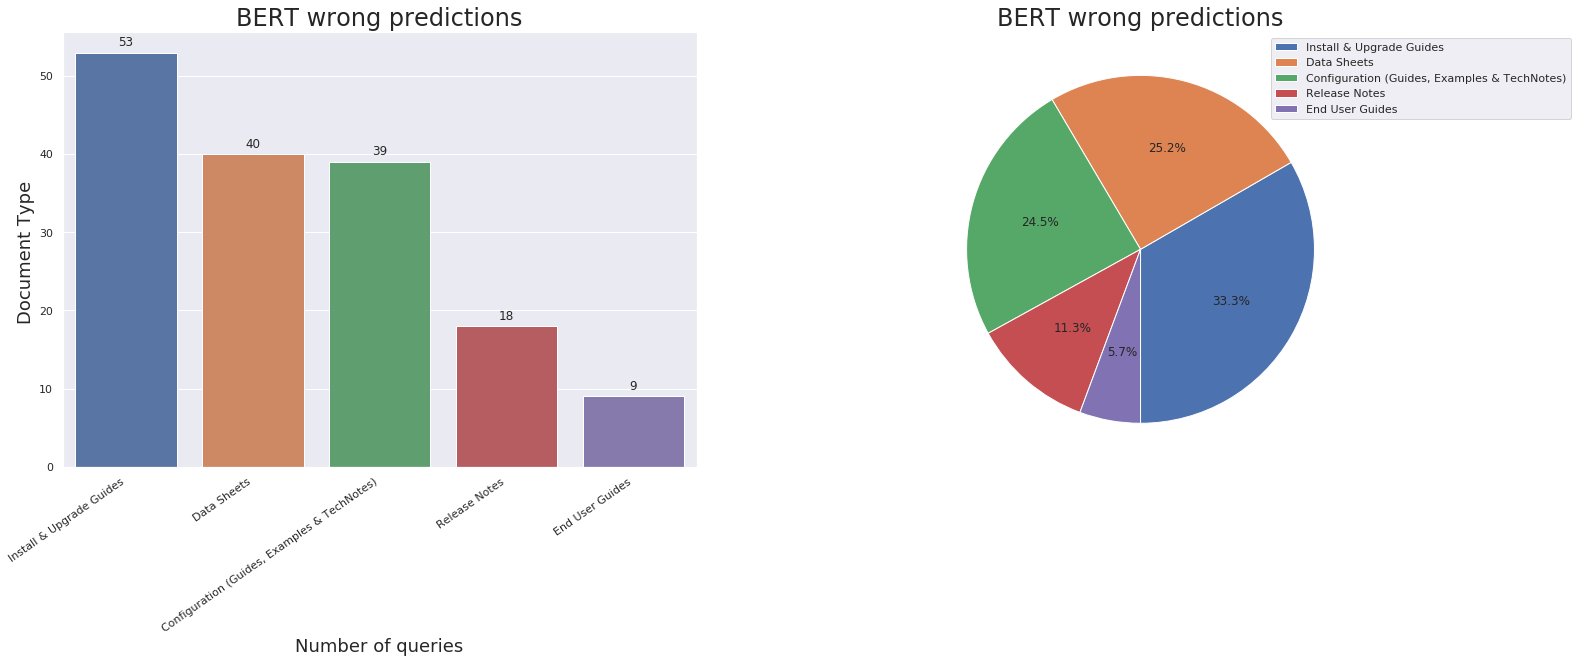

In [52]:
plot_repartition(df_bert_wrong, "BERT wrong predictions")

In [ ]:
plot_repartition(df_netbert_wrong, "NetBERT wrong predictions")

### 2.2. Is NetBERT at least as good as BERT ?

- Goal: 
    * Consider only the queries that BERT correclty classified, and run NetBERT on it. The purpose is to check if NetBERT also classifies correctly these queries.
    * This is to be expected, NetBERT should normally classifies correctly the queries that BERT had right, but in addition improves those that BERT had wrong.
- Analysis:
    * Overall, NetBERT predicts correclty ~0.96% of the predictions that BERT got right, meaning that NetBERT seems approximately as good as original BERT.
    * While original BERT seems to have difficulty predicting the 'Install & Upgrade Guides" class, NetBERT seems to solve this defect as in the ~0.04% that it got wrong, it is mainly the "Data Sheets" class that predicted badly.

Accuracy: 0.958


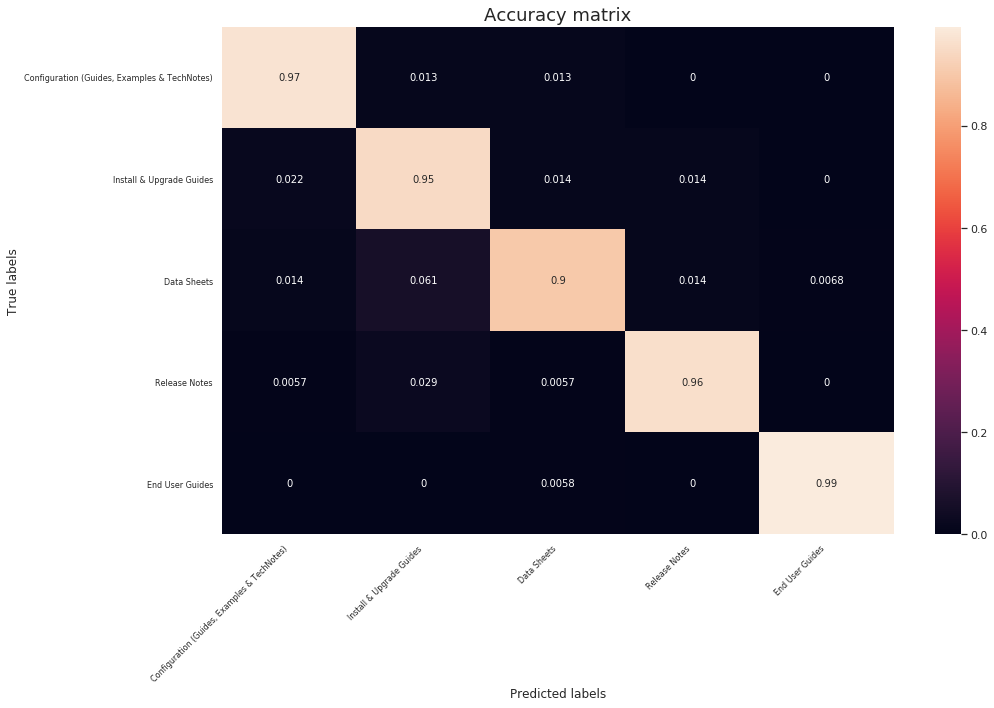

In [53]:
# Load scores.
result = load_results(dirpath=dirpath, filepath='scores_bert_right_preds.json')
print("Accuracy: {:.3f}".format(result['Accuracy']))

# Plot confusion matrix.
plot_confusion_matrix(result['conf_matrix'], list(class_mappings.values()))

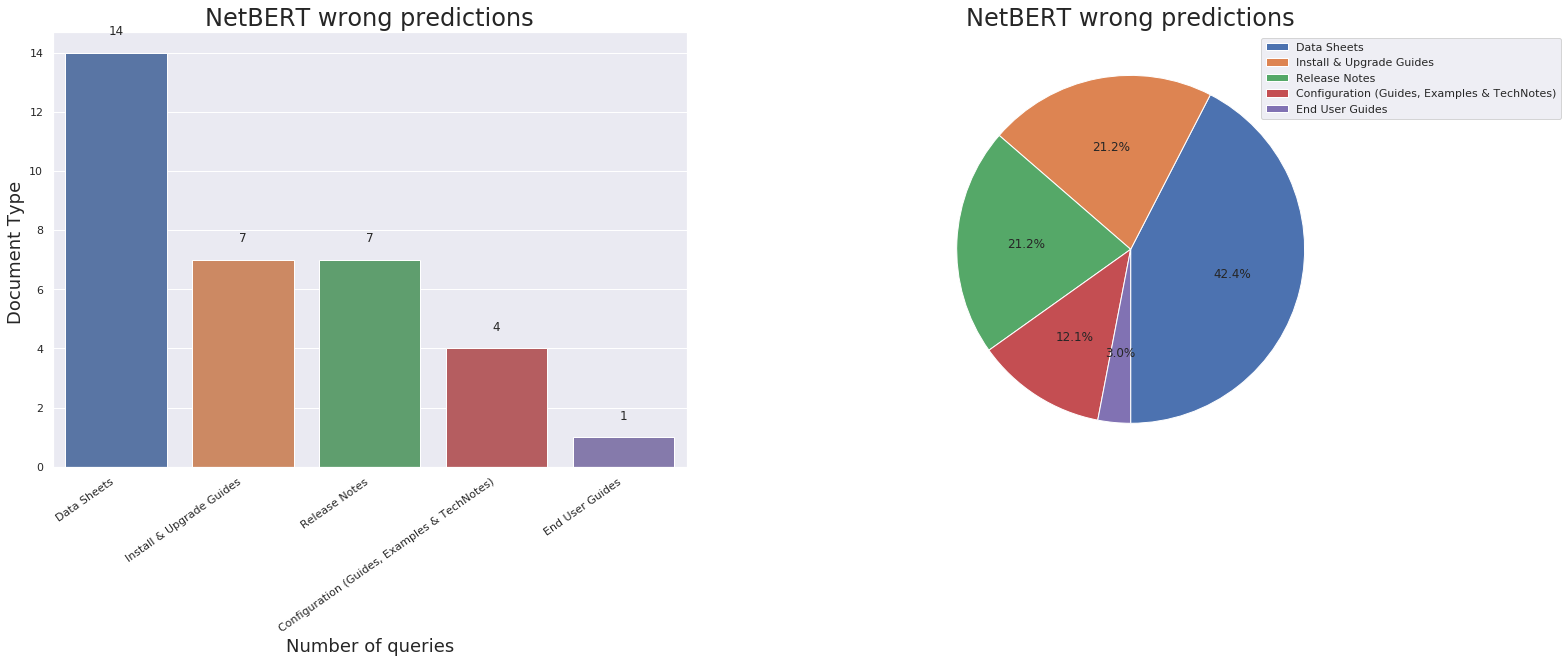

In [54]:
# Load dataset where NetBERT misclassified queries that BERT had correclty classified.
df_bert_right_netbert_wrong = load_dataset(dirpath, 'bert_right_netbert_wrong.csv', class_mappings)
plot_repartition(df_bert_right_netbert_wrong, "NetBERT wrong predictions")

In [55]:
# Display queries wrongly classified.
df_bert_right_netbert_wrong

,Sentence,Class,Prediction
0,dx80 current firmware,Data Sheets,Install & Upgrade Guides
1,Cisco 4000 Series ISR platforms,Install & Upgrade Guides,Release Notes
2,dx80 firmware,Data Sheets,Install & Upgrade Guides
3,2960x 24 pcl POE,Data Sheets,"Configuration (Guides, Examples & TechNotes)"
4,Catalyst 3750-X Series Switches: over Temperature,"Configuration (Guides, Examples & TechNotes)",Data Sheets
5,Switch / Cisco C2960X Catalyst 2960-X 24 GigE ...,Data Sheets,Install & Upgrade Guides
6,password recovery nexus,Install & Upgrade Guides,Release Notes
7,MDS NX-OS Release 6,Install & Upgrade Guides,Data Sheets
8,Cisco Catalyst 2960-X series (POE) end of life,Data Sheets,Install & Upgrade Guides
9,Advanced Malware Protection for Networks: Dete...,Data Sheets,End User Guides


### 2.3. How does NetBERT improve BERT ?

- Goal: Consider only the queries that BERT misclassified, and run NetBERT on it. The purpose is to analyze how NetBERT improves the misclassifications of BERT.
- Analysis:
    * A

Accuracy: 0.415


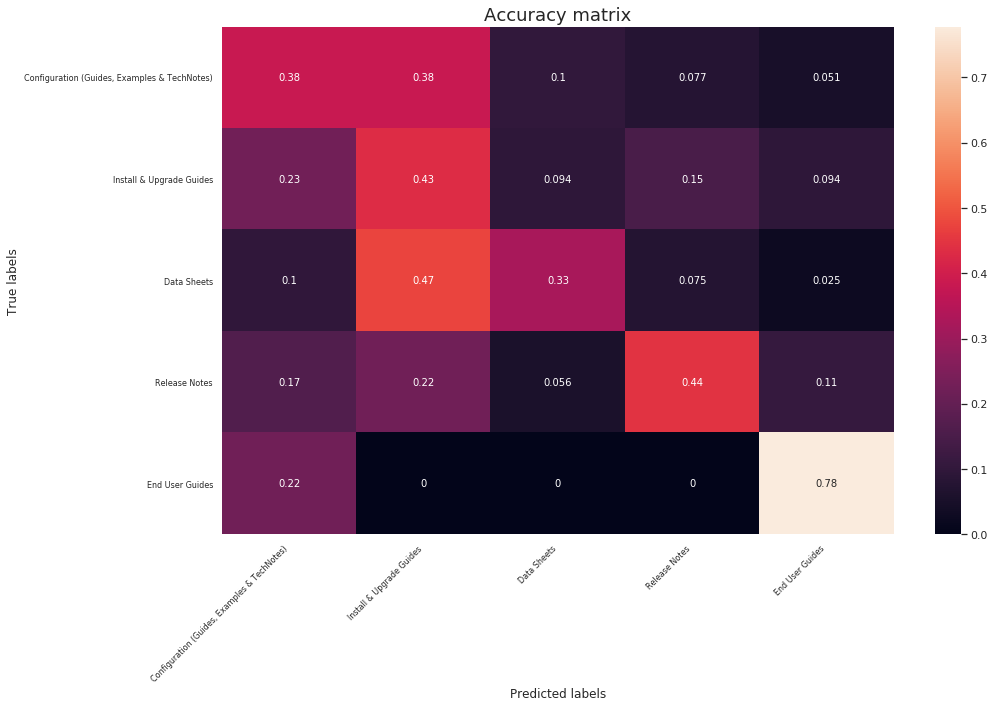

In [56]:
# Load scores.
result = load_results(dirpath=dirpath, filepath='scores_bert_wrong_preds.json')
print("Accuracy: {:.3f}".format(result['Accuracy']))

# Plot confusion matrix.
plot_confusion_matrix(result['conf_matrix'], list(class_mappings.values()))

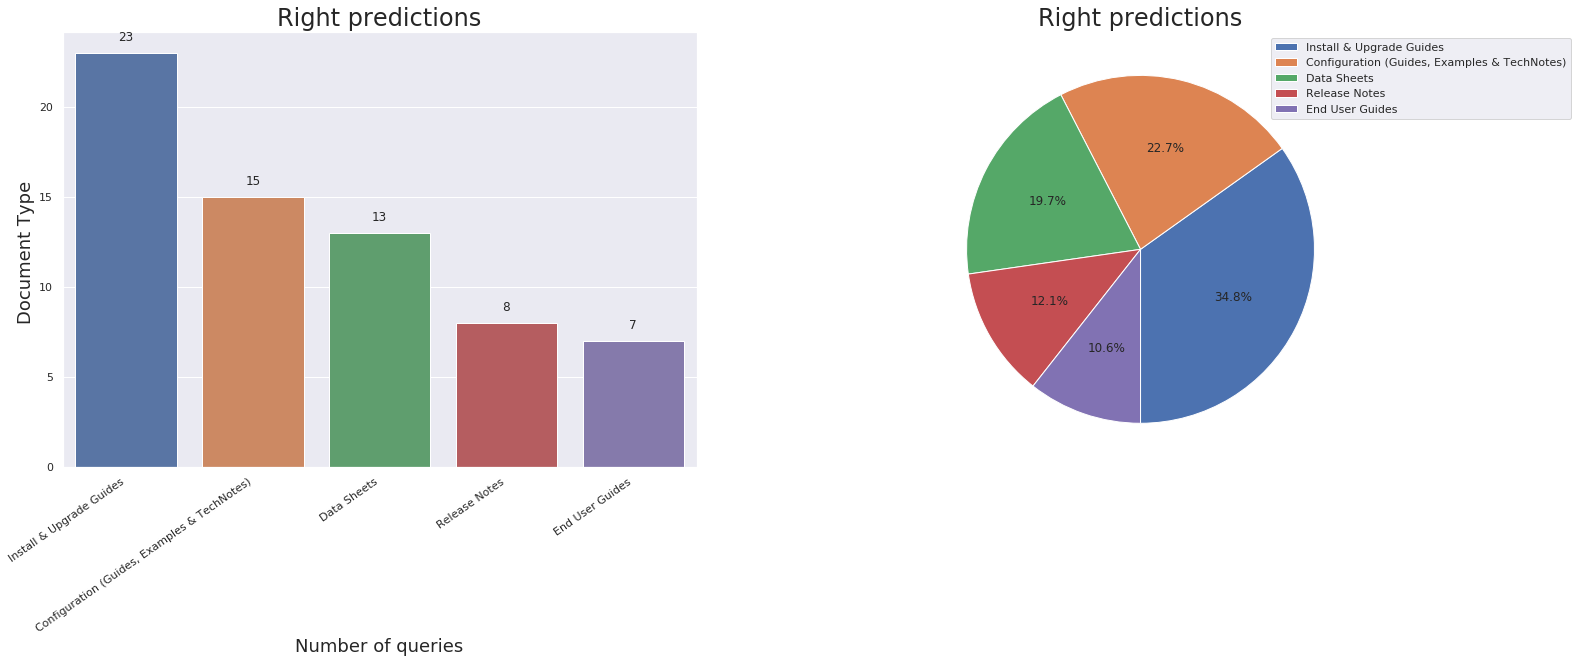

In [57]:
# Load dataset where NetBERT classified correclty queries that BERT misclassified (analyze improvement).
df_bert_wrong_netbert_right = load_dataset(dirpath, 'bert_wrong_netbert_right.csv', class_mappings)
plot_repartition(df_bert_wrong_netbert_right, "Right predictions")

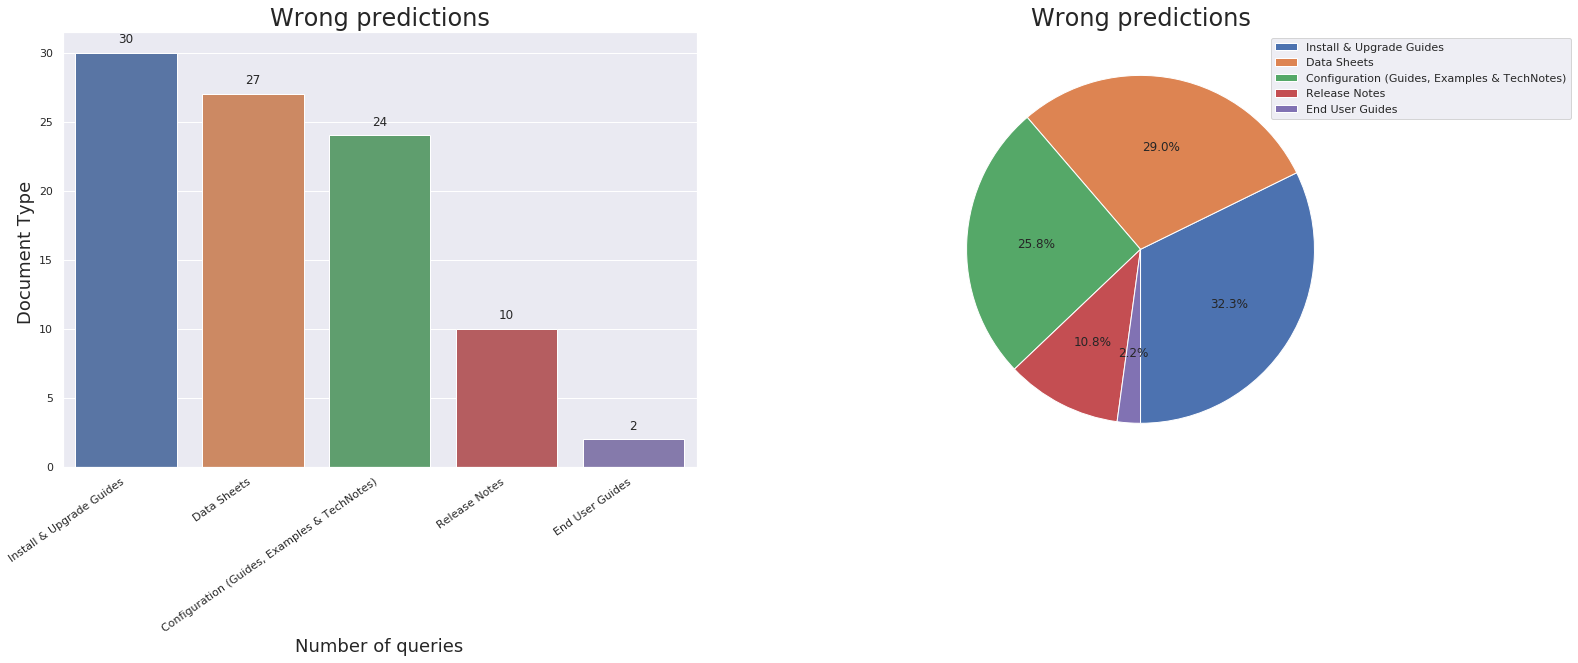

In [58]:
# Load dataset where NetBERT misclassified queries that BERT also misclassified (no improvement).
df_bert_wrong_netbert_right = load_dataset(dirpath, 'bert_wrong_netbert_wrong.csv', class_mappings)
plot_repartition(df_bert_wrong_netbert_right, "Wrong predictions")